<a href="https://colab.research.google.com/github/AadishWorkspace/AadishWorkspace/blob/main/predicting_the_global_gold_price_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
df = pd.read_csv('Gold Price (2013-2023).csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df

,Price,Open,High,Low
Date,,,,
2022-12-30,"1,826.20","1,821.80","1,832.40","1,819.80"
2022-12-29,"1,826.00","1,812.30","1,827.30","1,811.20"
2022-12-28,"1,815.80","1,822.40","1,822.80","1,804.20"
2022-12-27,"1,823.10","1,808.20","1,841.90","1,808.00"
2022-12-26,"1,809.70","1,805.80","1,811.95","1,805.55"
...,...,...,...,...
2013-01-08,"1,663.20","1,651.50","1,662.60","1,648.80"
2013-01-07,"1,647.20","1,657.30","1,663.80","1,645.30"
2013-01-04,"1,649.90","1,664.40","1,664.40","1,630.00"


In [ ]:
df=df.iloc[::-1]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2583 entries, 2013-01-02 to 2022-12-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   2583 non-null   object
 1   Open    2583 non-null   object
 2   High    2583 non-null   object
 3   Low     2583 non-null   object
dtypes: object(4)
memory usage: 100.9+ KB


In [ ]:
float_col=list(df.columns)

In [ ]:
for i in float_col:
    df[i] = df[i].str.replace(',', '').astype(float)

In [ ]:
df.head()

,Price,Open,High,Low
Date,,,,
2013-01-02,1689.9,1675.8,1695.0,1672.1
2013-01-03,1675.6,1688.0,1689.3,1664.3
2013-01-04,1649.9,1664.4,1664.4,1630.0
2013-01-07,1647.2,1657.3,1663.8,1645.3
2013-01-08,1663.2,1651.5,1662.6,1648.8


# EDA

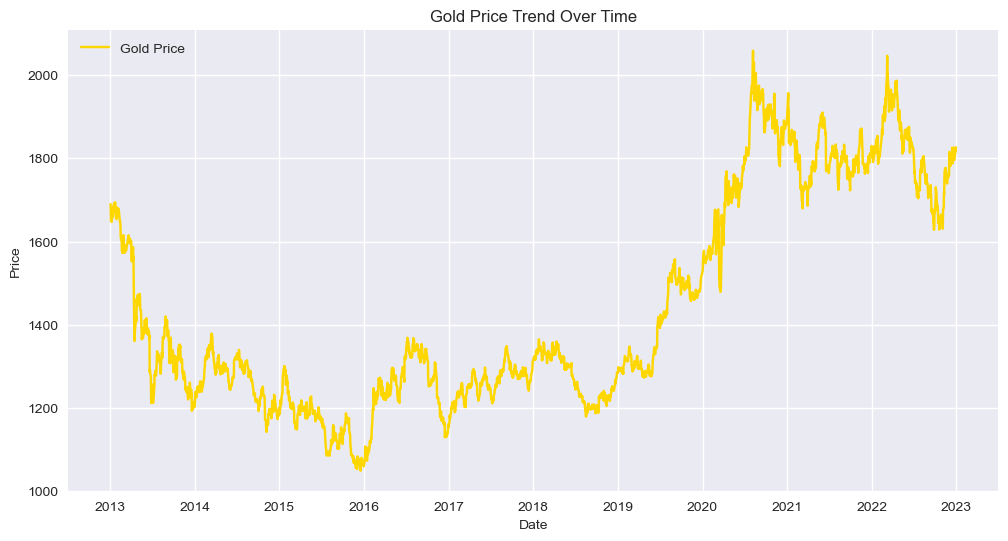

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Gold Price', color='gold')
plt.title('Gold Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

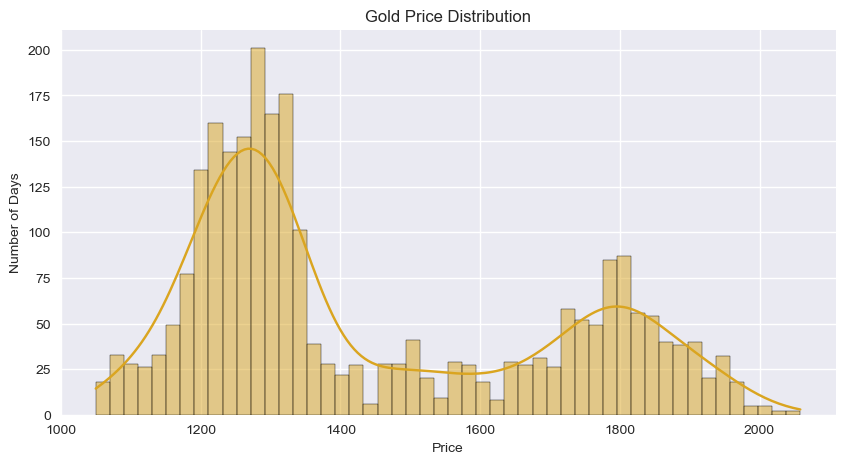

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], bins=50, color='goldenrod', kde=True)
plt.title('Gold Price Distribution')
plt.xlabel('Price')
plt.ylabel('Number of Days')
plt.grid(True)
plt.show()

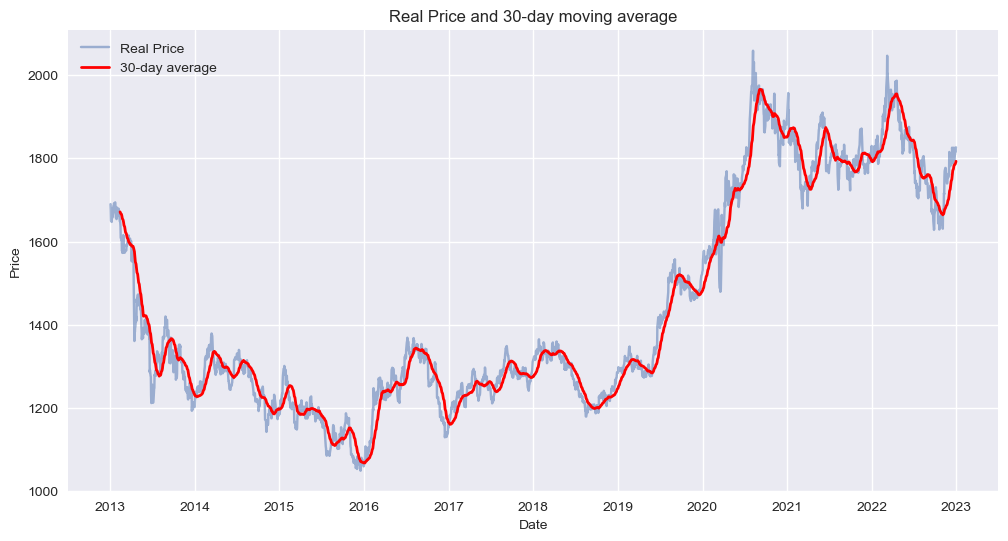

In [ ]:
rolling_mean = df['Price'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Real Price', alpha=0.5)
plt.plot(rolling_mean, label='30-day average', color='red', linewidth=2)
plt.title('Real Price and 30-day moving average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df['EMA20'] = df['Price'].ewm(span=10, adjust=True).mean()

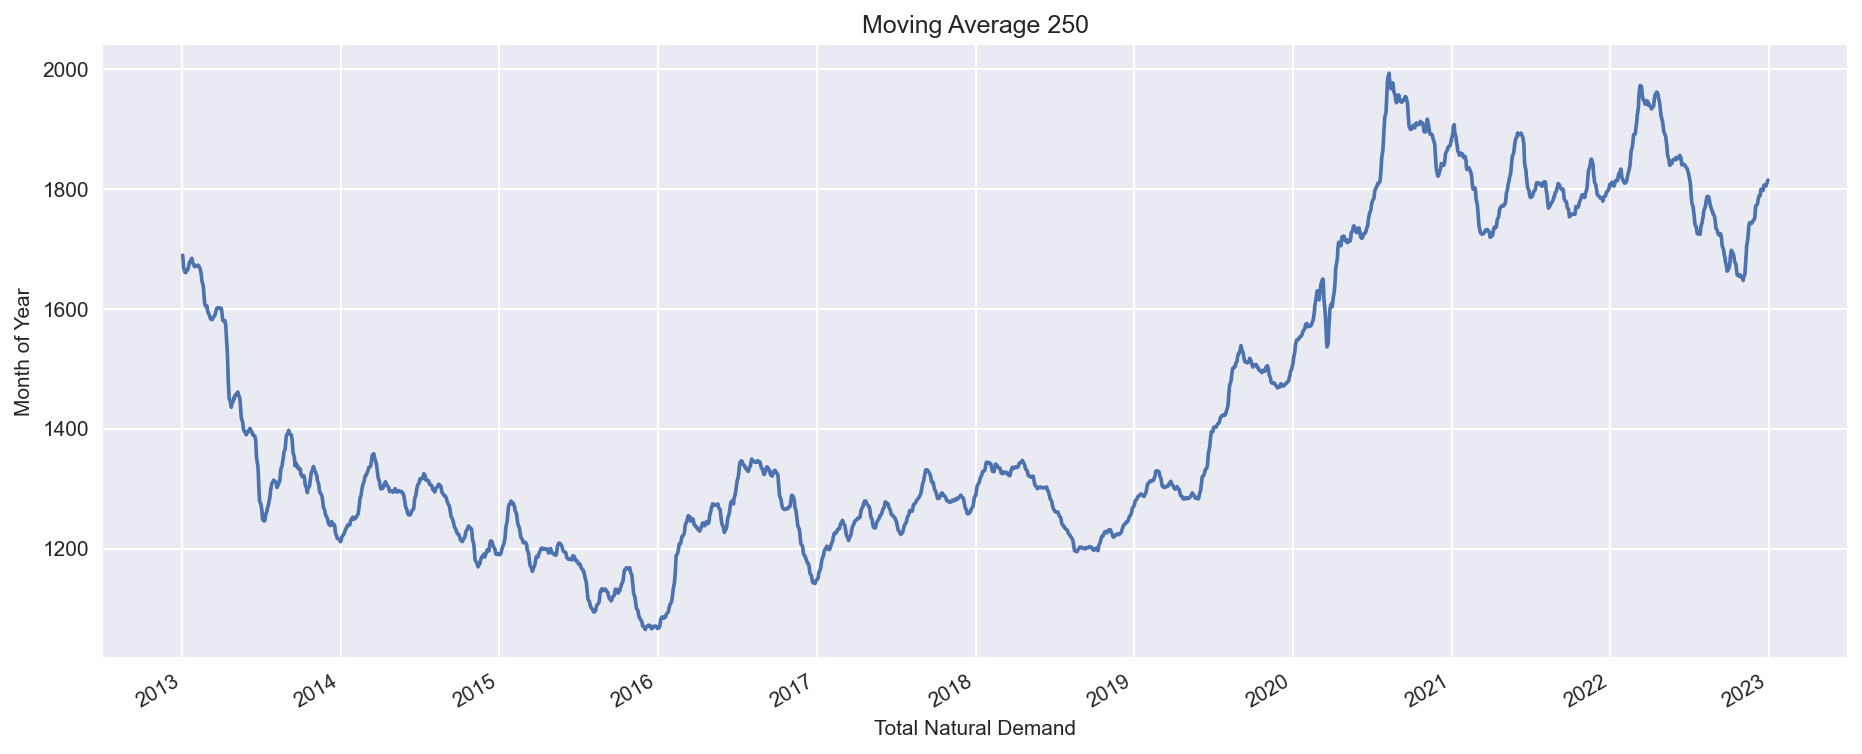

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
df.EMA20.plot()
plt.xlabel("Total Natural Demand")
plt.ylabel("Month of Year")
plt.title("Moving Average 250")
plt.show()

**We used the moving average as the target for this model because the volatility is lower.**

# Create a Model

In [ ]:
test_size = df[df.index.year == 2022].shape[0]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [ ]:
train = df.EMA20[:-test_size]
test = df.EMA20[-test_size-60:]

In [ ]:
train = scaler.transform(train.values.reshape(-1,1))
test = scaler.transform(test.values.reshape(-1,1))

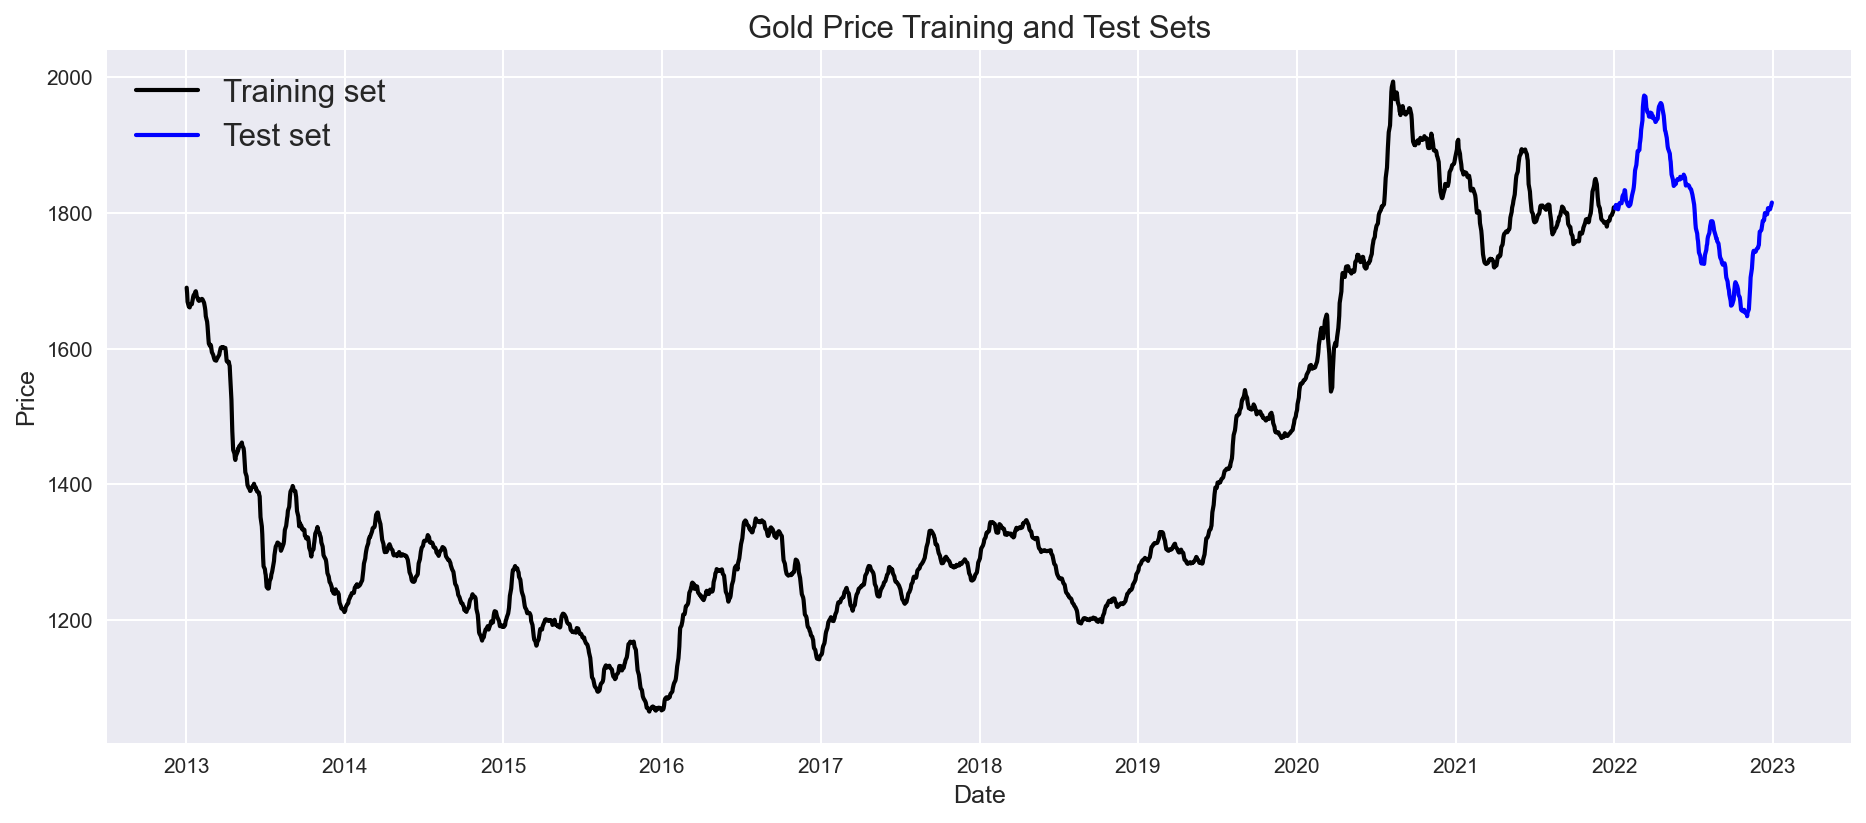

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df.index[:-test_size], df.EMA20[:-test_size], color='black', lw=2)
plt.plot(df.index[-test_size:], df.EMA20[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [ ]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length , len(data)):
        X.append(data[i-60:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 60
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(60, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0287
Epoch 2/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.2655e-04
Epoch 3/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.9649e-04
Epoch 4/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.9460e-04
Epoch 5/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.3399e-04
Epoch 6/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.1750e-04
Epoch 7/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.7552e-04
Epoch 8/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.4837e-04
Epoch 9/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.2534e-04
Epoch 10/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.4745e-04
Epoch 11/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.2736e-04
Epoch 12/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.2466e-04
Epoch 13/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.6177e-04
Epoch 14/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.5418e-04
Epoch 15/40
71/71 ━

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2264e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)
y_train_pred = scaler.inverse_transform(y_train)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
print(f'RMSE: {rmse}')

RMSE: 10.684851025331119


In [ ]:
r2 = r2_score(y_test_true , y_test_pred)
print(f'R2-Score : {r2}')

R2-Score : 0.9850127221773329


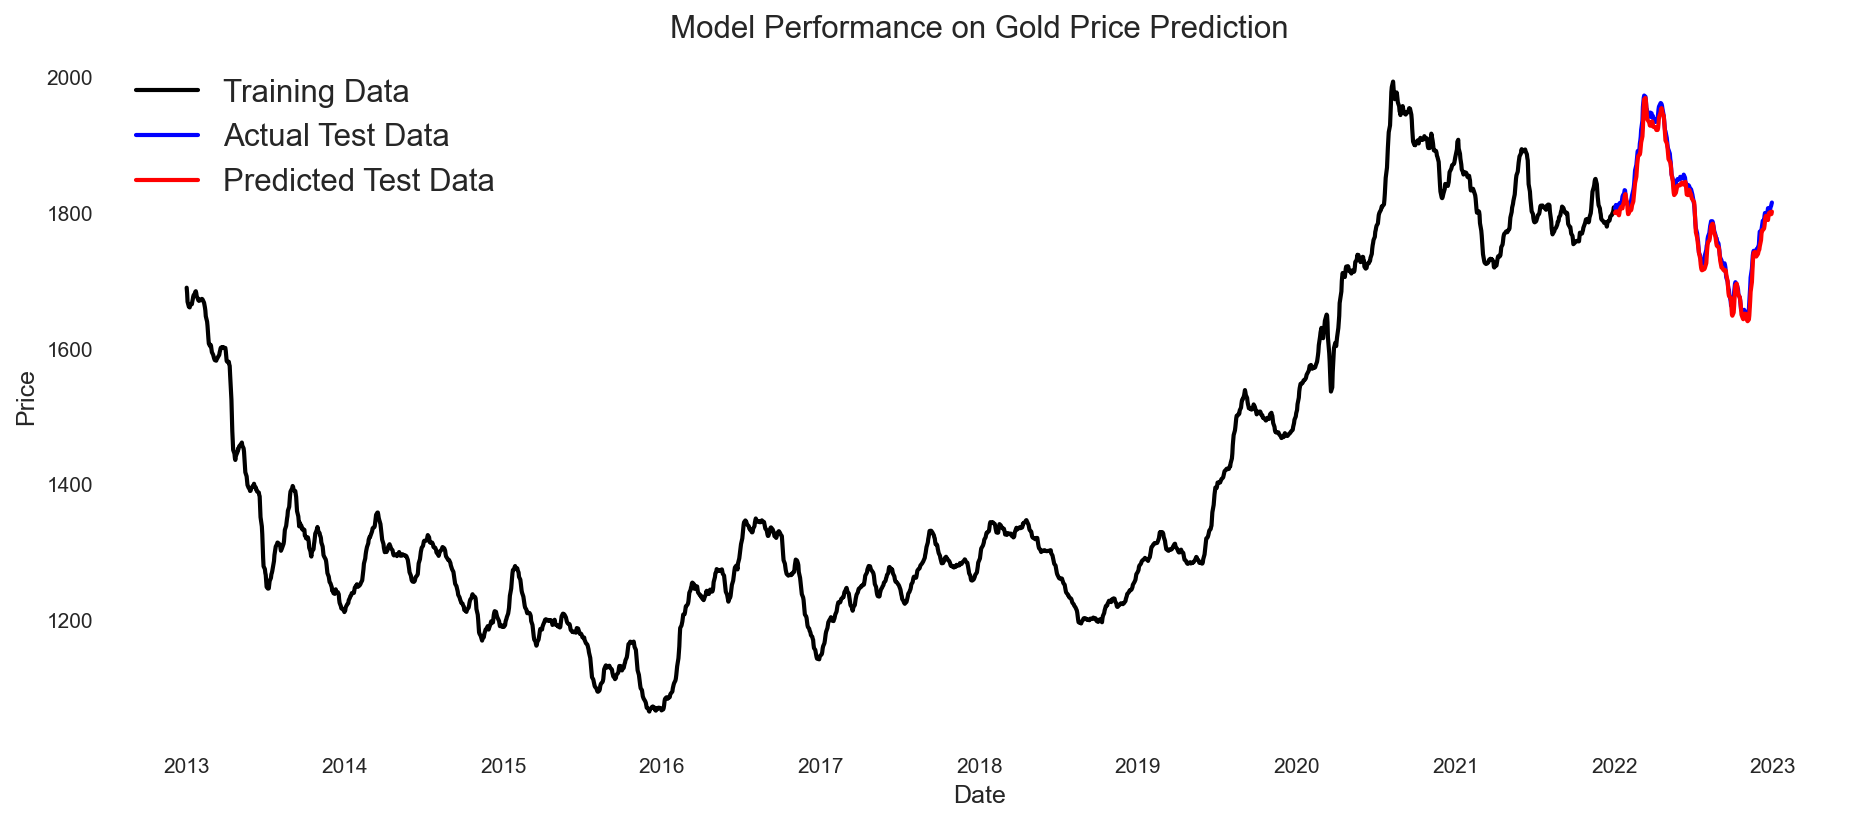

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df.index[:-test_size], scaler.inverse_transform(train), color='black', lw=2)
plt.plot(df.index[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.index[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Forecast for the next 2 months

In [ ]:
future_steps = 30 * 2
lookback = 24
last_sequence = test[-lookback:].reshape(1, lookback, 1)
future_preds = []

In [ ]:
for _ in range(future_steps):
    lstm_out = model.predict(last_sequence)
    future_preds.append(lstm_out[0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[[lstm_out[0][0]]]], axis=1)


future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [ ]:
start_date = pd.to_datetime('2023-01-01')
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='D')

In [ ]:
forecast_df = pd.DataFrame({
    'datetime': future_dates,
    'predicted_demand': future_preds.flatten()
})
forecast_df.set_index('datetime', inplace=True)

In [ ]:
forecast_df

,predicted_demand
datetime,
2023-01-01,1820.828857
2023-01-02,1826.536621
2023-01-03,1832.530518
2023-01-04,1838.665161
2023-01-05,1845.079224
2023-01-06,1851.887207
2023-01-07,1859.070190
2023-01-08,1866.611816
2023-01-09,1874.523560


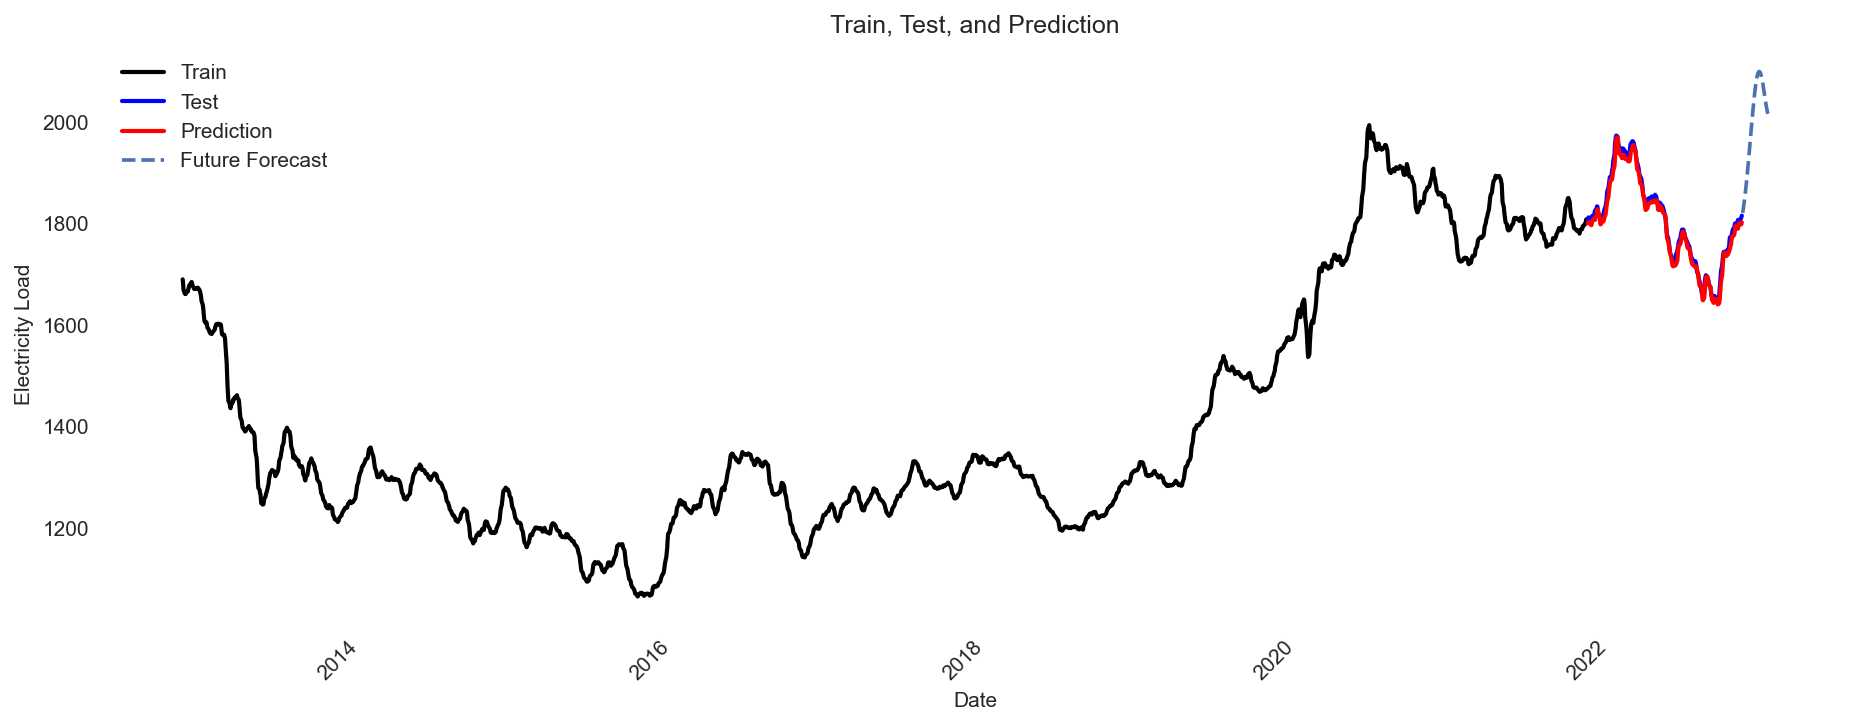

In [ ]:
plt.figure(figsize=(15, 5),dpi=150)

plt.plot(df.index[:-test_size], scaler.inverse_transform(train), color='black', lw=2,label='Train')
plt.plot(df.index[-test_size:], y_test_true, color='blue', lw=2, label='Test')
plt.plot(df.index[-test_size:], y_test_pred, color='red', lw=2,label='Prediction')
plt.plot(forecast_df.index, forecast_df['predicted_demand'], label='Future Forecast', linestyle='--')

plt.title('Train, Test, and Prediction')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.legend()
plt.xticks(rotation=45)
plt.show()

**As can be seen in the project, the model output is almost close to the actual changes in gold in 2023:**

![image-3.png](attachment:image-3.png)

# Examining the impact of "US inflation rate" and "US bank interest" on "global gold"

In [ ]:
df2 = pd.read_csv('FEDFUNDS.csv')
df3=pd.read_csv('CPI.csv')

In [ ]:
df2['observation_date'] = pd.to_datetime(df2['observation_date'])

In [ ]:
df5=df2[(df2['observation_date'].dt.year >= 2013) & (df2['observation_date'].dt.year <= 2022)]

In [ ]:
df_gold = df.copy()

In [ ]:
monthly_avg = df_gold['Price'].resample('M').mean()

In [ ]:
monthly_avg = monthly_avg.to_frame(name='Gold_Price')

In [ ]:
FEDFUNDS=list(df5['FEDFUNDS'])

In [ ]:
monthly_avg['FEDFUNDS'] = FEDFUNDS

In [ ]:
us_data = df3[df3['COUNTRY'] == 'United States']
us_data = us_data[us_data['COICOP_1999'] == 'All Items']
us_data = us_data[us_data['FREQUENCY'] == 'Monthly']
us_data = us_data[us_data['INDEX_TYPE'].str.contains('Consumer price index')]
us_data = us_data[us_data['TYPE_OF_TRANSFORMATION'] == 'Index']

In [ ]:
date_cols = [col for col in us_data.columns if '-' in col and ('M' in col or 'Q' in col)]

In [ ]:
years = [2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

In [ ]:
cpi=[]

In [ ]:
for i in years:
    for j in date_cols:
        if f'{i}-M' in j:
            cpi.append(j)

In [ ]:
cpi_num = []
for i in cpi:
    cpi_num.append(us_data[i].iloc[0])

In [ ]:
monthly_avg['CPI'] = cpi_num

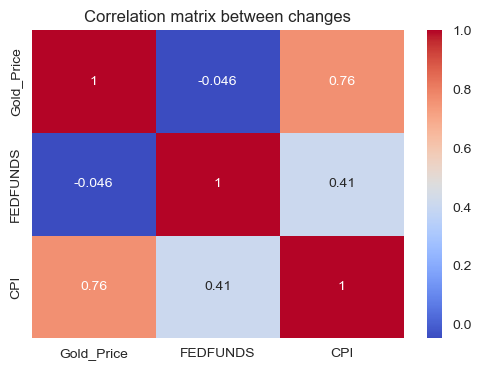

In [ ]:
corr = monthly_avg.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation matrix between changes")
plt.show()

The price of gold has a strong and positive relationship with inflation (CPI), but almost no relationship with interest rates (FEDFUNDS). Interest rates are also somewhat correlated with inflation.

In [ ]:
monthly_avg['Gold_Change'] = monthly_avg['Gold_Price'].pct_change() * 100

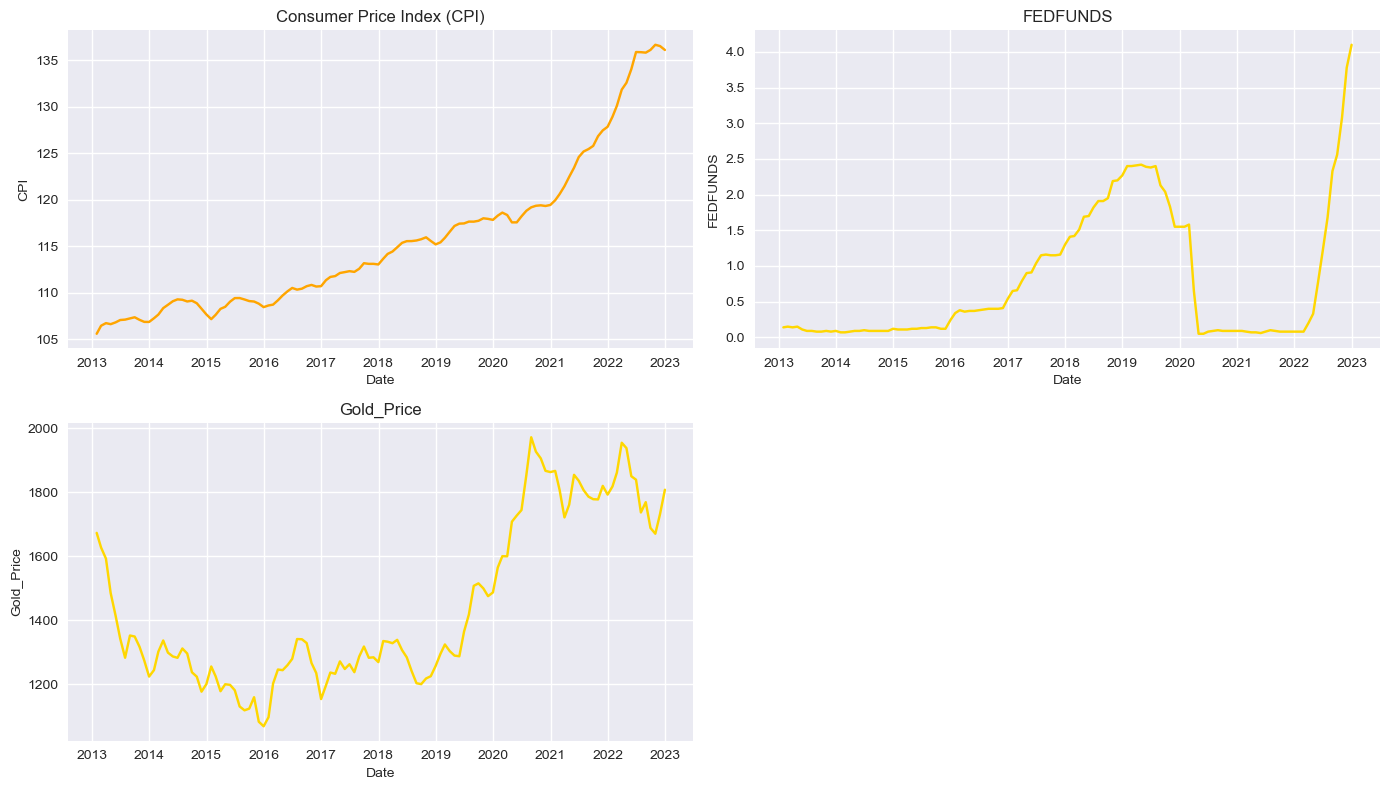

In [ ]:
plt.figure(figsize=(14,8))

plt.subplot(2, 2, 1)
plt.plot(monthly_avg.index, monthly_avg['CPI'], color='orange')
plt.title('Consumer Price Index (CPI)')
plt.xlabel('Date')
plt.ylabel('CPI')

plt.subplot(2, 2, 2)
plt.plot(monthly_avg.index, monthly_avg['FEDFUNDS'], color='gold')
plt.title('FEDFUNDS')
plt.xlabel('Date')
plt.ylabel('FEDFUNDS')

plt.subplot(2, 2, 3)
plt.plot(monthly_avg.index, monthly_avg['Gold_Price'], color='gold')
plt.title('Gold_Price')
plt.xlabel('Date')
plt.ylabel('Gold_Price')

plt.tight_layout()
plt.show()



- **CPI (inflation)** has grown steadily since 2013, but has jumped sharply since **2021**; that is, real inflation has been felt noticeably since then, and in 2020 this jump occurred after the Corona era and large injections of money by governments

- **Interest rates (FEDFUNDS)** have been low for most of the past decade, but have increased suddenly since **2022** to combat inflation.

- **Gold Price**:
    - Fluctuating and sometimes falling from 2013 to 2018.
    - Strong growth from 2019 to 2021, with inflation and interest rates low.
    - Slightly down since 2022, but still high.

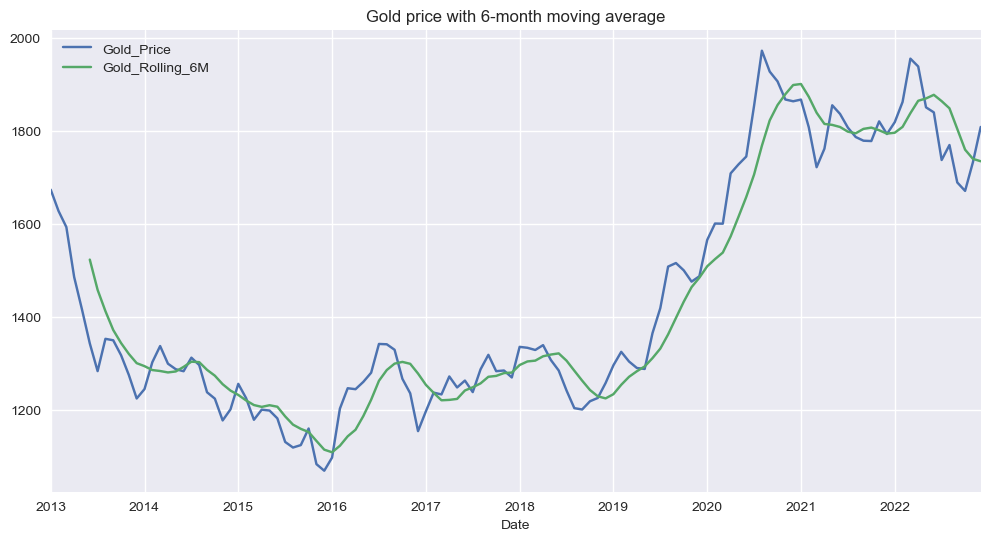

In [ ]:
monthly_avg['Gold_Rolling_6M'] = monthly_avg['Gold_Price'].rolling(window=6).mean()
monthly_avg[['Gold_Price', 'Gold_Rolling_6M']].plot(figsize=(12,6), title='Gold price with 6-month moving average')
plt.show()

The price of gold was on a downward trend between 2013 and 2015, and after a period of volatility, it has experienced significant growth since 2019, especially during the COVID-19 pandemic, when economic uncertainty caused investors to flee to safe haven assets like gold. After 2021, the market has stabilized and seen less volatility. The 6-month moving average also shows that the overall direction of the gold market has been bullish, with short periods of price correction.

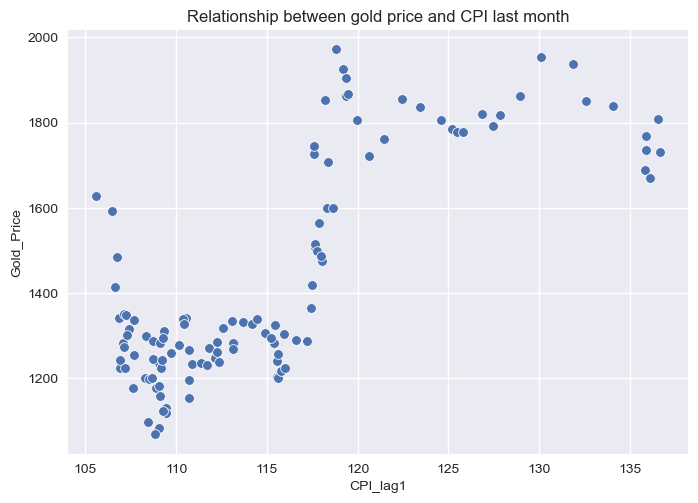

In [ ]:
monthly_avg['CPI_lag1'] = monthly_avg['CPI'].shift(1)

sns.scatterplot(x=monthly_avg['CPI_lag1'], y=monthly_avg['Gold_Price'])
plt.title('Relationship between gold price and CPI last month')
plt.show()

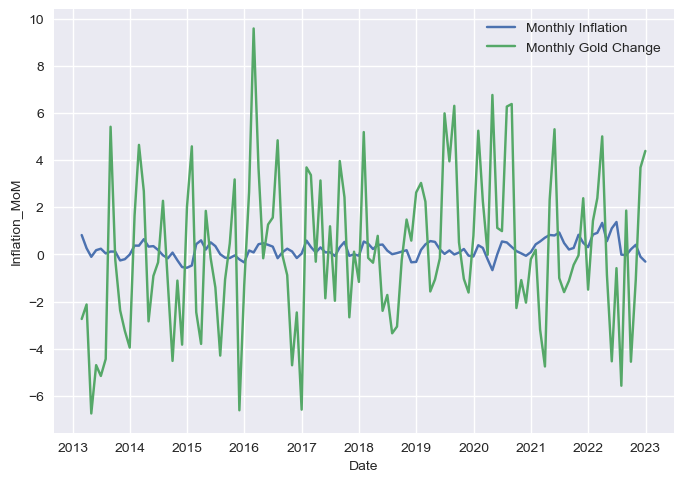

In [ ]:
monthly_avg['Inflation_MoM'] = monthly_avg['CPI'].pct_change() *100

sns.lineplot(x=monthly_avg.index, y=monthly_avg['Inflation_MoM'], label='Monthly Inflation')
sns.lineplot(x=monthly_avg.index, y=monthly_avg['Gold_Price'].pct_change() * 100, label='Monthly Gold Change')
plt.legend()
plt.show()

The chart above shows that inflation rates are directly related to the price of gold. Whenever inflation increases, the price of gold increases. Of course, the Federal Reserve and the coronavirus may also have an impact.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def trend_years(num_column):
    result = seasonal_decompose(monthly_avg[num_column], model='additive', period=12)
    result.plot()
    plt.suptitle(f'Seasonal Decomposition of {num_column}', fontsize=16)
    plt.tight_layout()
    plt.show()

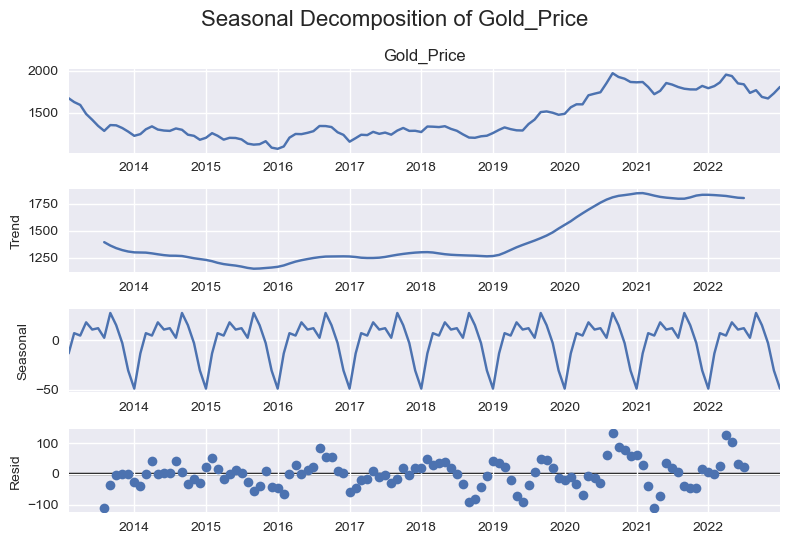

In [ ]:
trend_years('Gold_Price')

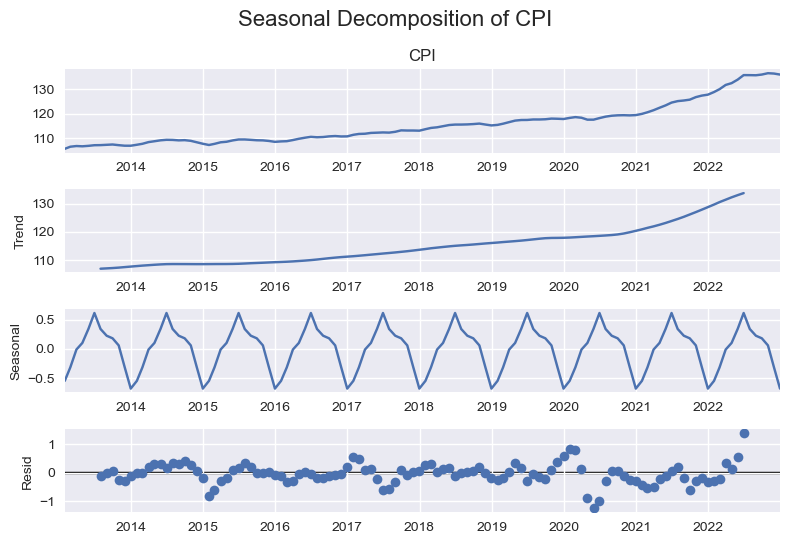

In [ ]:
trend_years('CPI')

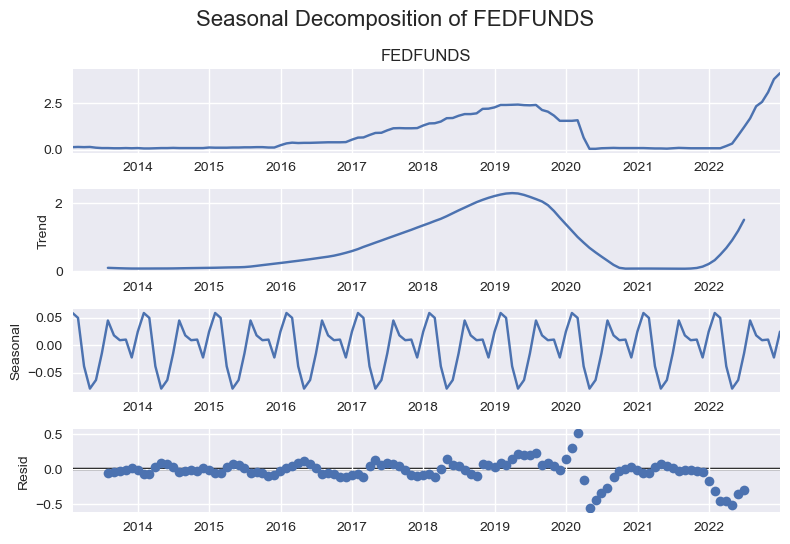

In [ ]:
trend_years('FEDFUNDS')

In [ ]:
monthly_avg['Year'] = monthly_avg.index.year
monthly_avg['Month'] = monthly_avg.index.month

In [ ]:
monthly_gold_avg = monthly_avg.groupby('Month')['Gold_Price'].mean()
monthly_cpi_avg = monthly_avg.groupby('Month')['CPI'].mean()
monthly_FED_avg = monthly_avg.groupby('Month')['FEDFUNDS'].mean()

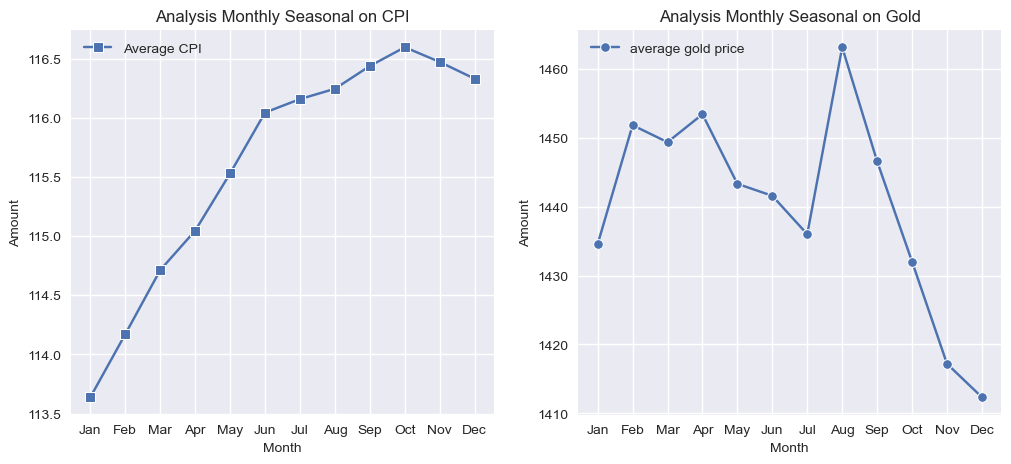

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.lineplot(x=monthly_cpi_avg.index, y=monthly_cpi_avg.values, marker='s', label='Average CPI')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Analysis Monthly Seasonal on CPI')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

sns.lineplot(x=monthly_gold_avg.index, y=monthly_gold_avg.values, marker='o', label='average gold price')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Analysis Monthly Seasonal on Gold')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

plt.show()

Americans turn to gold to preserve their capital after every inflation spike.

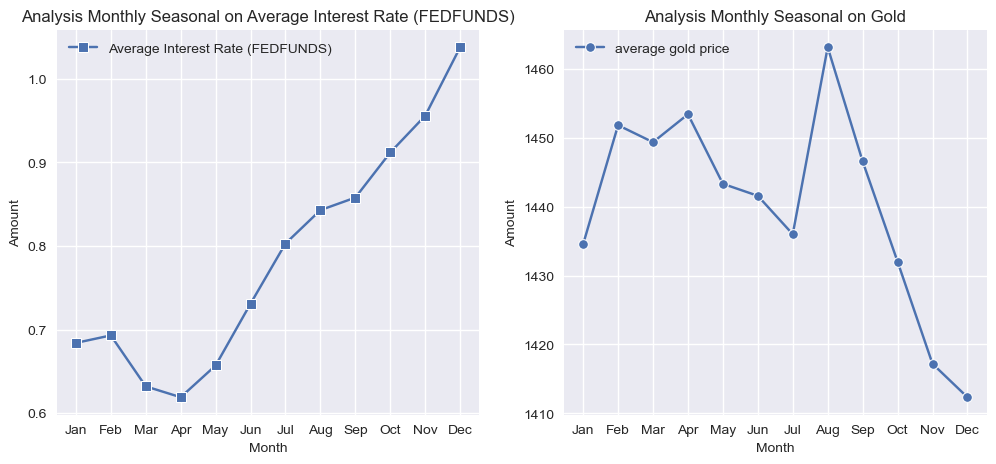

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.lineplot(x=monthly_FED_avg.index, y=monthly_FED_avg.values, marker='s', label='Average Interest Rate (FEDFUNDS)')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Analysis Monthly Seasonal on Average Interest Rate (FEDFUNDS)')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(x=monthly_gold_avg.index, y=monthly_gold_avg.values, marker='o', label='average gold price')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Analysis Monthly Seasonal on Gold')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

plt.show()

As bank interest rates increase, the price of gold stabilizes and people are less likely to buy gold.

In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

monthly_avg['Season'] = monthly_avg['Month'].apply(get_season)

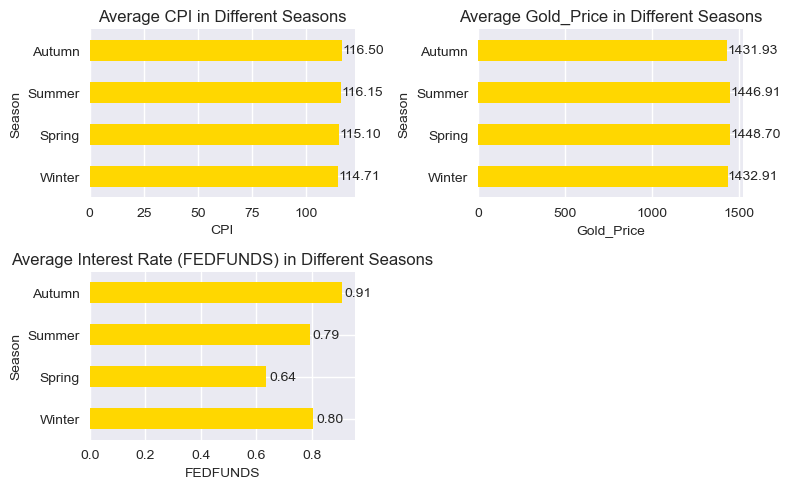

In [ ]:
plt.figure(figsize=(16,3))

plt.subplot(2, 2, 1)
seasonal_gold_avg = monthly_avg.groupby('Season')['CPI'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])
ax = seasonal_gold_avg.plot(kind='barh', color='gold', figsize=(8,5), title='Average CPI in Different Seasons')

for index, value in enumerate(seasonal_gold_avg):
    plt.text(value + 0.2, index, f'{value:.2f}', va='center')

plt.xlabel('CPI')


plt.subplot(2, 2, 2)
seasonal_gold_avg = monthly_avg.groupby('Season')['Gold_Price'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])
ax = seasonal_gold_avg.plot(kind='barh', color='gold', figsize=(8,5), title='Average Gold_Price in Different Seasons')

for index, value in enumerate(seasonal_gold_avg):
    plt.text(value + 0.2, index, f'{value:.2f}', va='center')

plt.xlabel('Gold_Price')

plt.subplot(2, 2, 3)

seasonal_gold_avg = monthly_avg.groupby('Season')['FEDFUNDS'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])
ax = seasonal_gold_avg.plot(kind='barh', color='gold', figsize=(8,5), title='Average Interest Rate (FEDFUNDS) in Different Seasons')

for index, value in enumerate(seasonal_gold_avg):
    plt.text(value + 0.01, index, f'{value:.2f}', va='center')

plt.xlabel('FEDFUNDS')

plt.tight_layout()
plt.show()

- **For buying gold**: **Autumn** is suitable
- **For selling gold**: **Spring** is suitable
- **For buying gold** (CPI effect): **Winter** is better because inflation is lower.
- **For bank interest rates**, it is higher in the **Autumn and winter**.

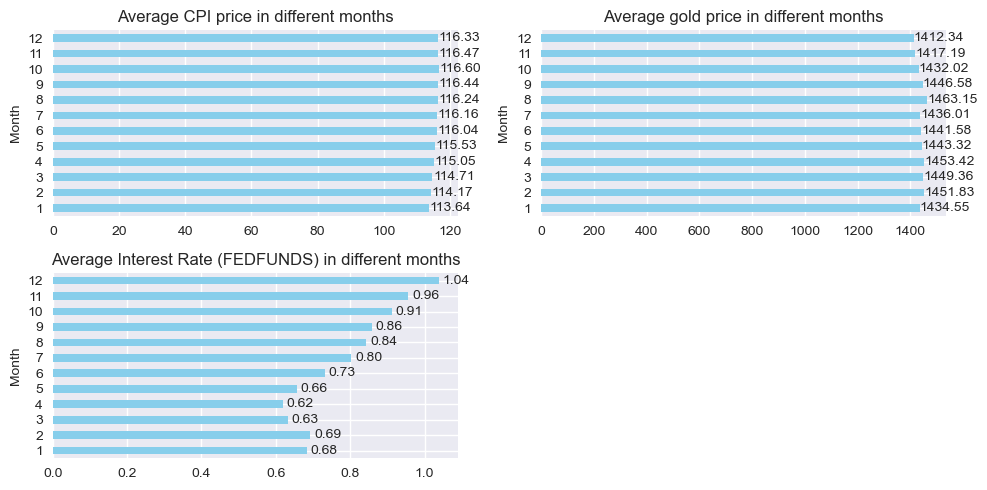

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(2, 2, 1)
monthly_CPI_avg = monthly_avg.groupby('Month')['CPI'].mean()
monthly_CPI_avg.plot(kind='barh', figsize=(10,5), color='skyblue', title='Average CPI price in different months')
for index, value in enumerate(monthly_CPI_avg):
    plt.text(value + 0.2, index, f'{value:.2f}', va='center')



plt.subplot(2, 2, 2)
monthly_gold_avg = monthly_avg.groupby('Month')['Gold_Price'].mean()
monthly_gold_avg.plot(kind='barh', figsize=(10,5), color='skyblue', title='Average gold price in different months')
for index, value in enumerate(monthly_gold_avg):
    plt.text(value + 0.2, index, f'{value:.2f}', va='center')


plt.subplot(2, 2, 3)

monthly_FED_avg = monthly_avg.groupby('Month')['FEDFUNDS'].mean()
monthly_FED_avg.plot(kind='barh', figsize=(10,5), color='skyblue', title='Average Interest Rate (FEDFUNDS) in different months')
for index, value in enumerate(monthly_FED_avg):
    plt.text(value + 0.01, index, f'{value:.2f}', va='center')
plt.tight_layout()
plt.show()

- In the last months of every year, **bank interest rates** and **inflation** increase in the United States.
- Gold purchases by Americans increase in the middle of each year, and gold prices are lower in the last and first months of each year.